# A Long-Term Memory Agent

The agent can store, retrieve, and use memories to enhance its interactions with users.



The key idea is that by saving memories, the agent persists information about users that is shared across multiple conversations (threads), which is different from memory of a single conversation that is already enabled by LangGraph's persistence.


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()


from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    google_api_key= os.getenv("GOOGLE_API_KEY")
)

In [2]:
from typing import List

from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

VectorStore for memories

In [3]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

recall_vector_store = InMemoryVectorStore(embeddings)

Memory tools

In [4]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

In [5]:
tools = [save_recall_memory, search_recall_memories]

llm_with_tools = llm.bind_tools(tools)

Defining State

In [6]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)



In [7]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]


"""
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
"""

'\nclass MessagesState(TypedDict):\n    messages: Annotated[list[AnyMessage], add_messages]\n\nclass State(TypedDict):\n    messages: Annotated[list, add_messages]\n\n'

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

In [9]:

def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """

    chain = prompt | llm_with_tools

    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = chain.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

### Building the graph

In [10]:
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

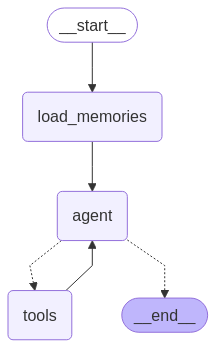

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Running it

In [12]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

In [13]:
#user id is critical
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "my name is John")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (3bffdefe-9038-4b97-94e7-1c0bad9955a8)
 Call ID: 3bffdefe-9038-4b97-94e7-1c0bad9955a8
  Args:
    memory: user's name is John


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

user's name is John


Update from node: agent
================================== Ai Message ==================================

Hello John! It's nice to meet you. I've made a note of your name. How can I help you today?




In [14]:
for chunk in graph.stream({"messages": [("user", "i love pizza")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ["user's name is John"]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (29fc01b0-6956-40b7-ad50-eb38de63ec10)
 Call ID: 29fc01b0-6956-40b7-ad50-eb38de63ec10
  Args:
    memory: John loves pizza


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John loves pizza


Update from node: agent
================================== Ai Message ==================================

Got it, John! Pizza is a classic. Do you have a favorite kind of pizza or a go-to place?




In [15]:
for chunk in graph.stream(
    {"messages": [("user", "yes -- pepperoni!")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza', "user's name is John"]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (4f6d1087-b94f-4a79-947a-ae2190a159d0)
 Call ID: 4f6d1087-b94f-4a79-947a-ae2190a159d0
  Args:
    memory: John's favorite pizza is pepperoni


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John's favorite pizza is pepperoni


Update from node: agent
================================== Ai Message ==================================

Ah, pepperoni! Can't go wrong with a classic like that, John. It's definitely a popular choice.




In [16]:
for chunk in graph.stream(
    {"messages": [("user", "i also just moved to new york")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ["John's favorite pizza is pepperoni", 'John loves pizza', "user's name is John"]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (a4a0af90-0423-494a-83a7-b4035a52a1c0)
 Call ID: a4a0af90-0423-494a-83a7-b4035a52a1c0
  Args:
    memory: John just moved to New York


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John just moved to New York


Update from node: agent
================================== Ai Message ==================================

That's a big change, John! Welcome to New York! That's exciting. How are you settling in so far? Have you had a chance to explore any pizza places here yet? New York is famous for its pizza, after all!




Now we can use the saved information about our user on a different thread. Let's try it out:



In [17]:
config = {"configurable": {"user_id": "1", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "where should i go for dinner?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza', "John's favorite pizza is pepperoni", 'John just moved to New York']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  search_recall_memories (4df37280-efba-449a-b337-bfe4d5eafcfa)
 Call ID: 4df37280-efba-449a-b337-bfe4d5eafcfa
  Args:
    query: dinner preferences or location


Update from node: tools
================================= Tool Message =================================
Name: search_recall_memories

["John loves pizza", "John's favorite pizza is pepperoni", "John just moved to New York"]


Update from node: agent
================================== Ai Message ==================================

Given that you just moved to New York and I know you're a big fan of pizza, especially pepperoni, how about checking out a highly-rated pizza spot in the city? New York certainly has no shortage of amazing pizzerias!


